# EEMD + LSTM

## Data Description

    - Raw data: Historical Product Demand.csv

    - Input data: Data on 8x augmentation of demand records by selecting 8 representative items

    - Product code: 'Product_0025', 'Product_0739', 'Product_0901', 'Product_1154',
                    'Product_1248', 'Product_1295', 'Product_1378', 'Product_2004'
            

    - Size of Data: 116392 rows × 4 columns

    - Features: Date, Product_Code, Product_Category, Order_Demand

    - Period: 2012-01-01 ~ 2017-01-09


---

In [2]:
# DataFrame
import pandas as pd
import numpy as np
import random
from datetime import datetime, date

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import warnings
#from pandas.errors import SettingWithCopyWarning
#warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

#Save the log
import os
import time
import pickle

# EEMD
from PyEMD import EEMD

# LSTM
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MSE

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Metric 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score

## Data Explore

In [3]:
df = pd.read_csv("../Data/JW_daily_univar_data.csv")
df.rename(columns={'증빙일':'Date', '자재내역':'Product', '납품수량': 'y'}, inplace=True)
df

,Date,Product,y
0,2015-02-23,가나칸정-500T,2387
1,2015-02-24,가나칸정-500T,143
2,2015-02-25,가나칸정-500T,2037
3,2015-02-26,가나칸정-500T,0
4,2015-02-27,가나칸정-500T,0
...,...,...,...
11152,2022-12-27,트루패스구강붕해정8mg-30T,128
11153,2022-12-28,트루패스구강붕해정8mg-30T,0
11154,2022-12-29,트루패스구강붕해정8mg-30T,10
11155,2022-12-30,트루패스구강붕해정8mg-30T,261


---

## EEMD
    * 시계열 그래프를 ensembled IMF (앙상블 내재모드 함수)로 분해
    * n 개의 eIMFs와  1개의 Residual 생성

In [4]:
# 수요 그래프를 n개의 앙상블된 내재모드함수(IMF)로 분해
# 그래프의 변동성이 클수록, IMF의 개수 증가
def eemd_fit(df, trials, max_imf=-1):
    
    # Define signal
    t = np.array(df['Date']) # x-axis
    s = np.array(df['y']) # y-axis
    
    # EEMD 객체 생성
    eemd = EEMD(trials=trials) # trials: EMD 횟수(default:100)
    
    # 극값을 감지하는 방법으로 parabolic 방법을 선택
    emd = eemd.EMD
    emd.extrema_detection="parabol"
    
    # eIMFs로 분해
    eIMFs = eemd.eemd(s, t, max_imf=max_imf) # max_imf: IMF 제한 개수(-1: 없음)
    nIMFs = eIMFs.shape[0] # eIMF의 개수
    
    # 분해된 eIMFs와 잔차를 변수에 할당
    imfs, residue = eemd.get_imfs_and_residue()
    
    # 앙상블 IMFs 들의 DataFrame 생성
    all_eIMFs_df = pd.DataFrame(eIMFs).transpose() 
    all_eIMFs_df[nIMFs] = residue # residue 열 마지막 열로 추가
    all_eIMFs_df.insert(0, 'Date', df['Date']) # Date 열 추가
    
    return all_eIMFs_df, nIMFs # eIMF+Residue들로 이루어진 df, eIMF의 개수

### eIMFs 데이터프레임 추출

In [5]:
# eIMF들을 추출하여, Date와 y로 이루어진 데이터프레임 추출하고 딕셔너리에 저장
def extract_eIMFs(all_eIMFs_df, nIMFs):
    all_eIMFs_dict = {}
    # IMF개수+Residue(1) 만큼 반복
    for i in range(nIMFs+1):
        tmp_df = all_eIMFs_df[['Date', i]] # n번째 eIMF에 해당하는 날짜와 값 추출
        tmp_df.columns=['Date', 'y'] # i -> y 로 열이름 변경
        all_eIMFs_dict[f'eIMFs_{i}'] = tmp_df # n번째 eIMF 정보(마지막은 Residue) 딕셔너리에 저장
                            # df.columns = ['Date', 'y']
    return all_eIMFs_dict # {eIMFs_1: df1, eIMFs_2: df2, ...}

### Split the train and test set
- Input
     data: dataframe with dates and Demand data
     
- output
    - train: ~ 2012-06-30
    
    - test :  2022-07-01 ~ 2012-12-31

In [45]:
def split_data(eIMF_df, time_steps): 

    train_end = len(eIMF_df[eIMF_df['Date']<'2022-07-01'])

    y = eIMF_df.filter(['y']).values # y(수요량) 값
    
    # Minmax로 0~1 사이에 값이 오도록 정규화
    sc = MinMaxScaler() # 객체 생성
    
    # Scaling the train Data 
    y_train_scaled = sc.fit_transform(y[:train_end, :])

    X_train = [] 
    y_train = []
    for i in range(time_steps, train_end-1): # pred_days days shifted
        X_train.append(y_train_scaled[i-time_steps:i, 0]) # time steps 만큼 sliding window
        y_train.append(y_train_scaled[i, 0]) # pred_days days shifted
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    # Reshape X_train for LSTM -> (batch_size, time_steps, features)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
    
    # Test Data (SC set by train set)
    y_test_scaled = sc.transform(y[train_end:, :])
    
    X_test = []
    y_test = eIMF_df.iloc[train_end+time_steps:] # pred_days days shifted
    y_test['y_norm'] = y_test_scaled[time_steps:].reshape(-1).copy() # pred_days days shifted
    
    # test data 개수만큼 반복
    for i in range(time_steps, len(y_test_scaled)): # pred_days days shifted
        X_test.append(y_test_scaled[i-time_steps:i, 0])
    
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

    return X_train, y_train, X_test, y_test, sc

### LSTM

In [59]:
def LSTM_model(X_train, y_train, X_val, y_val, X_test, sc, epochs):
    # LSTM 모델 객체 생성
    my_LSTM_model = Sequential() 
    
    # 첫 번째 LSTM 레이어 구성
    # 활성화 함수는 ReLU를 사용하며, return_sequences=True로 지정하여 다음 LSTM 레이어의 입력으로 사용할 수 있도록 함
    my_LSTM_model.add(LSTM(512, activation='tanh',return_sequences=True, input_shape=(X_train.shape[1],1)))
    
    # 두 번째 LSTM 레이어 구성
    # 활성화 함수는 ReLU를 사용하며, return_sequences=False로 지정하여 마지막 LSTM 레이어임을 나타냄
    my_LSTM_model.add(LSTM(256, activation = 'tanh',return_sequences=False))
    
    # Fully connected 레이어들 추가
    # 마지막 레이어에서는 출력의 unit 개수를 1로 설정하여 1개의 값을 출력
    my_LSTM_model.add(Dense(128))
    my_LSTM_model.add(Dense(64))
    my_LSTM_model.add(Dense(32))
    my_LSTM_model.add(Dense(1))
    
    # 모델 컴파일
    my_LSTM_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), # Adam optimizer 사용
                          loss = 'mean_squared_error', # 손실 함수로는 평균 제곱 오차 사용
                          metrics=['mape','mae']) # 성능 지표로는 MAPE와 MAE를 사용
    #조기종료 조건
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # 모델 Fitting
    my_LSTM_model.fit(X_train, # 입력 데이터
                      y_train, # 출력 데이터
                      epochs = epochs, # epoch 수
                      batch_size = 16, # batch size
                      validation_data=(X_val, y_val),
                      callbacks=[early_stopping],# validation에 따른 조기종료
                      verbose = 1) # 학습 상태를 출력
    
    # Test 데이터 예측
    LSTM_prediction = my_LSTM_model.predict(X_test) # 예측값 얻기
    LSTM_prediction_normalized = LSTM_prediction # 예측값을 저장하되, normalize된 값 저장
    LSTM_prediction = sc.inverse_transform(LSTM_prediction) # denormalize된 예측값 저장
    
    # 모델 객체와 예측값 반환
    return my_LSTM_model, LSTM_prediction, LSTM_prediction_normalized

In [87]:
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner import RandomSearch
import tempfile

def build_model(hp):
    model = Sequential()
    
    model.add(LSTM(units=hp.Int('lstm_1_units', min_value=32, max_value=512, step=32), 
                   activation=hp.Choice('activation_1', ['relu', 'tanh']),
                   return_sequences=True, 
                   input_shape=(30,1)))

    model.add(LSTM(units=hp.Int('lstm_2_units', min_value=32, max_value=512, step=32), 
                   activation=hp.Choice('activation_2', ['relu', 'tanh']),
                   return_sequences=False))

    model.add(Dense(hp.Int('dense_1_units', min_value=32, max_value=128, step=32), 
                    activation=hp.Choice('activation_3', ['relu', 'tanh'])))
    model.add(Dense(hp.Int('dense_2_units', min_value=32, max_value=128, step=32), 
                    activation=hp.Choice('activation_4', ['relu', 'tanh'])))
    model.add(Dense(1))

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='mean_squared_error',
        metrics=['mape', 'mae'])

    return model

def LSTM_model(X_train, y_train, X_val, y_val, X_test, sc, epochs):

    with tempfile.TemporaryDirectory() as temp_dir:
        tuner = RandomSearch(
            build_model,
            objective='val_loss',
            max_trials= 30,
            directory=temp_dir,
            project_name='temp_project')

    stop_early = EarlyStopping(monitor='val_loss', patience=10)

    tuner.search(X_train, y_train,
                 epochs = epochs,
                 validation_data=(X_val, y_val),
                 callbacks=[stop_early])

    best_model = tuner.get_best_models(num_models=1)[0]
    best_model.summary()

    LSTM_prediction = best_model.predict(X_test)
    LSTM_prediction_normalized = LSTM_prediction 
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)
    
    return best_model, LSTM_prediction, LSTM_prediction_normalized

In [6]:
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner import RandomSearch
import tempfile
def build_model(hp):
    
    model = Sequential()
    num_LSTM_layers = hp.Int('num_LSTM_layers', 1, 2)
    for i in range(num_LSTM_layers):
        if i == 0:
            model.add(Bidirectional(LSTM(units=hp.Int(f'LSTM_units_1', min_value=64, max_value=512, step=64),
                           activation= 'tanh',
                           input_shape=(None,1),
                           return_sequences=True)))
            model.add(Dropout(0.3))
        else:
            model.add(Bidirectional(LSTM(units=hp.Int(f'LSTM_units_{i+1}', min_value=64, max_value=256, step=32),
                           activation= 'tanh',
                           return_sequences=True)))
            model.add(Dropout(0.3))
    
    model.add(Dropout(0.2))
    num_Dense_layers = hp.Int('num_Dense_layers', 1, 2)
    for i in range(num_Dense_layers):

            model.add(TimeDistributed(Dense(hp.Int(f'Dense_units_{i+1}', min_value=16, max_value=32, step=16), 
                                        activation= 'relu')))
            model.add(Dropout(0.3))
    model.add(TimeDistributed(Dense(1)))

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 5e-4])),
                  loss='mean_squared_error',
                  metrics='mae')

    return model

def LSTM_model(X_train, y_train, X_val, y_val, X_test, sc, epochs):

    with tempfile.TemporaryDirectory() as temp_dir:
        tuner = RandomSearch(
            build_model,
            objective='val_loss',
            max_trials= 30,
            directory=temp_dir,
            project_name='temp_project')

    stop_early = EarlyStopping(monitor='val_loss', patience=10)

    tuner.search(X_train, y_train,
                 epochs = epochs,
                 validation_data=(X_val, y_val),
                 callbacks=[stop_early])

    best_model = tuner.get_best_models(num_models=1)[0]
    best_model.summary()

    LSTM_prediction = best_model.predict(X_test)
    LSTM_prediction_normalized = LSTM_prediction 
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)
    
    return best_model, LSTM_prediction, LSTM_prediction_normalized


### EEMD+LSTM

In [7]:
'''
EEMD의 결과로 분해된 ensembled IMF들에 대해
각각 LSTM으로 예측하여 예측값을 얻은 후,
마지막에 합산하여 전체 결과를 파악함
'''
def EEMD_LSTM(all_eIMFs_dict, time_steps, epochs):

    model_dict = {}
    pred_dict = {}
    
    # 모든 eIMF에 대해 LSTM 모델 학습 및 예측 실행
    for i in all_eIMFs_dict.keys():
        print(f'--------Total: 0~{len(all_eIMFs_dict)-1} eIMFs, Now: {i} --------')
        
        # 현재 eIMF 데이터 가져오기
        eIMF_df = all_eIMFs_dict[i]
        
        # 학습 데이터와 테스트 데이터 분리
        X_train, y_train, X_val, y_val, X_test, y_test, sc = ts_train_val_test(eIMF_df, time_steps)
        
        # LSTM 모델 학습 및 저장
        my_LSTM_model, LSTM_prediction, LSTM_prediction_normalized = LSTM_model(X_train, y_train, X_val, y_val, X_test, sc, epochs)
        model_dict[i] = my_LSTM_model # 딕셔너리에 모델 정보 저장
        
        # 예측 결과 저장
        y_test.reset_index(drop=True, inplace=True)
        pred_df = pd.DataFrame({'Pred': LSTM_prediction.reshape(-1) ,'Pred_norm': LSTM_prediction_normalized.reshape(-1)})
        res_df = pd.concat([y_test, pred_df], axis=1)
        res_df.set_index('Date', inplace=True)
        res_df = res_df.resample('D').first() # 증강된 데이터가 아닌, Actual값들과 비교
        # res_df: ['y', 'y_norm', 'Pred', 'Pred_norm'], index='Date'
        pred_dict[i] = res_df
        
    # 모델과 예측값 딕셔너리 반환
    return model_dict, pred_dict

### Total Result

In [8]:
def make_all_result_df(pred_dict):
    all_df = pd.DataFrame()
    for tmp_df in pred_dict.values():
        all_df = pd.concat([all_df, tmp_df], axis=1)
    pred_df = all_df['Pred'].sum(axis=1)
    actual_df = all_df['y'].sum(axis=1)
    
    all_result_df = pd.DataFrame({'Pred': pred_df, 'y': actual_df})
    all_result_df.loc[all_result_df['Pred']<0, 'Pred']=0 # 음수 예측 값은 0으로 대치
    
    # 날짜(Date) 열은 정규화하지 않으므로 제외
    result_norm = all_result_df[['Pred', 'y']]
    
    # 전체 결과 MinMaxScaler를 이용하여 정규화
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(result_norm)
    
    # 정규화된 데이터를 데이터 프레임에 반영합니다.
    all_result_df['Pred_norm'] = normalized_data[:,0]
    all_result_df['y_norm'] = normalized_data[:,1]
    return all_result_df

## Plot the result

In [9]:
def actual_pred_plot(product_code, pred_dict, all_result_df, metric_df, normalize=False):
    today = date.today()
    """
    Plot the actual vs predition and save the figure in the given directory
    """
    # 전체 결과도 PLOT 하기 위해 딕셔너리에 추가
    pred_dict['all_result'] = all_result_df
    
    save_path = os.path.join("Result", "EEMD+LSTM_Result", product_code+f'_{today.month:02d}{today.day:02d}')
    if normalize: save_path += "_normalized"
        
    for i, pred_df in enumerate(pred_dict.values()):
        img_n = len(pred_dict)
        title = f"Pred Actual Plot - ({i+1}/{len(pred_dict)-1})'s eIMF"
        actual = pred_df['y']
        pred = pred_df['Pred']
        save_name = f'{product_code}_eIMF_{i+1}'
        if i == img_n-1: # All result
            title = f"{product_code}-All Result"
            save_name = f'{product_code}_all_result'
        if normalize:
            title += "(Normalized)"
            actual = pred_df['y_norm']
            pred = pred_df['Pred_norm']
            
        plt.figure(figsize=(16, 8))
        plt.title(title, fontsize=20)
        plt.xlabel("Time", fontsize=14)
        plt.ylabel("Order Demand", fontsize=14)
        plt.plot(actual, label ='Actual', alpha=0.6)
        plt.plot(pred, label='Prediction', alpha=0.8)
        plt.legend(loc="upper right")
        
        # Plot 결과 저장
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        # save the figure
        today_date = f'_{today.month:02d}{today.day:02d}'
        plt.savefig(os.path.join(save_path, save_name+'.png'))
    # Metric도 함께 저장
    metric_df.to_csv(os.path.join(save_path, f'{product_code}_Metric.csv'))
    all_result_df.to_csv(os.path.join(save_path, f'{product_code}_total_result.csv'))
    del pred_dict['all_result']
        
    plt.close('all') # close all figures to free up memory

## Save and Load the model

In [90]:
def save_model(product_code, model_dict):
    today = date.today()
    folder_path = 'Result/EEMD+LSTM_Result/Model'
    file_name = f'{product_code}_{today.month:02d}{today.day:02d}.pkl'
    save_path = os.path.join(folder_path, file_name)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    # 객체를 pickle 파일로 저장
    with open(save_path, 'wb') as f:
        pickle.dump(model_dict, f)
    return model_dict

In [91]:
# 학습된 모델 load
def load_model(file_name):
    file_path = f'Result/EEMD+LSTM_Result/Model/{file_name}'
    
    with open(file_path, 'rb') as file:
        model_dict= pickle.load(file)
    
    return best_model

## Metrics

In [92]:
# Model Metric
def mase(training_series, testing_series, prediction_series):
    n = training_series.shape[0]
    d = np.abs(np.diff(training_series)).sum() / (n-1)
    
    errors = np.abs(testing_series - prediction_series)
    return errors.mean() / d

def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / (actual+1)))

# 정규화 된 지표
def nrmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred, squared=False)
    target_mean = np.mean(y_true)
    nrmse = mse / target_mean
    return nrmse

# 정규화 된 지표
def nmae(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    target_mean = np.mean(y_true)
    nmae = mae / target_mean
    return nmae

In [93]:
def calculate_metrics(pred_df, normalize):
    # 계산된 메트릭을 저장하기 위해 데이터프레임 초기화
    metric_df = pd.DataFrame(columns=['MAPE', 'RMSE', 'MAE', 'NRMSE', 'NMAE', 'R2'])

    # 정규화 옵션이 True인 경우 정규화된 데이터 사용, 
    # 그렇지 않으면 원래 데이터 사용
    if normalize:
        actual = pred_df['y_norm']
        pred = pred_df['Pred_norm']
    else:
        actual = pred_df['y']
        pred = pred_df['Pred']

    # 메트릭 계산
    # MASE = mase(np.array(train_series), np.array(actual), pred) 
    MAPE = mape(actual, pred) 
    RMSE = mean_squared_error(actual, pred)**0.5 
    MAE = mean_absolute_error(actual,pred) 
    NRMSE = nrmse(actual,pred) 
    NMAE = nmae(actual,pred) 
    R2 = r2_score(actual, pred)
    # RMSLE = mean_squared_log_error(actual, pred)**0.5 

    # 계산된 메트릭을 데이터프레임에 추가
    tmp_df = pd.DataFrame({'MAPE':[round(MAPE, 4)],
                           'RMSE':[round(RMSE, 4)],
                           'MAE':[round(MAE, 4)],
                           'NRMSE':[round(NRMSE, 4)],
                           'NMAE':[round(NMAE, 4)],
                           'R2': [round(R2, 4)]})

    # 메트릭 데이터프레임에 결과 추가
    metric_df = pd.concat([metric_df, tmp_df])
    return metric_df

---

## Check the Result

In [94]:
def make_metric_df(product_code, pred_dict, all_result_df, normalize):
    today = date.today()

    metric_df = pd.DataFrame(columns=['MAPE', 'RMSE', 'MAE', 'NRMSE', 'NMAE', 'R2'])
    for i, pred_df in pred_dict.items():
        imf_df = calculate_metrics(pred_df, normalize=normalize)
        metric_df = pd.concat([metric_df, imf_df])
    
    imf_idx = pd.Index(['eIMF_'+str(i+1) for i in range(len(pred_dict))]) # changed result_dict to pred_dict
    metric_df.index = imf_idx # Assign the created index to metric_df
    # 마지막 행은 전체 결과
    metric_df = pd.concat([metric_df, calculate_metrics(all_result_df, normalize=normalize)], axis=0)
    metric_df = metric_df.rename(index={metric_df.index[-1]: 'All'}) 
    
    return metric_df

In [52]:
product_code = 'Product_1378' # 예측하고자 하는 코드 입력
product_df = df[df['Product_Code']== product_code].reset_index(drop=True)
    
# EEMD 수행
all_eIMFs_df, nIMFs = eemd_fit(product_df, 100)
# EEMD 결과에서 각 eIMFs' DF 추출
all_eIMFs_dict = extract_eIMFs(all_eIMFs_df, nIMFs)

In [55]:
X_train.shape

(1243, 30, 1)

In [79]:
eIMF_df = all_eIMFs_dict['eIMFs_0']
X_train, y_train, X_val, y_val, X_test, y_test, sc = ts_train_val_test(eIMF_df, 30)

C:\Users\7info\AppData\Local\Temp\ipykernel_13460\1459628612.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test.loc[:, 'y_norm'] = ts_test_scaled[time_steps:].reshape(-1).copy()


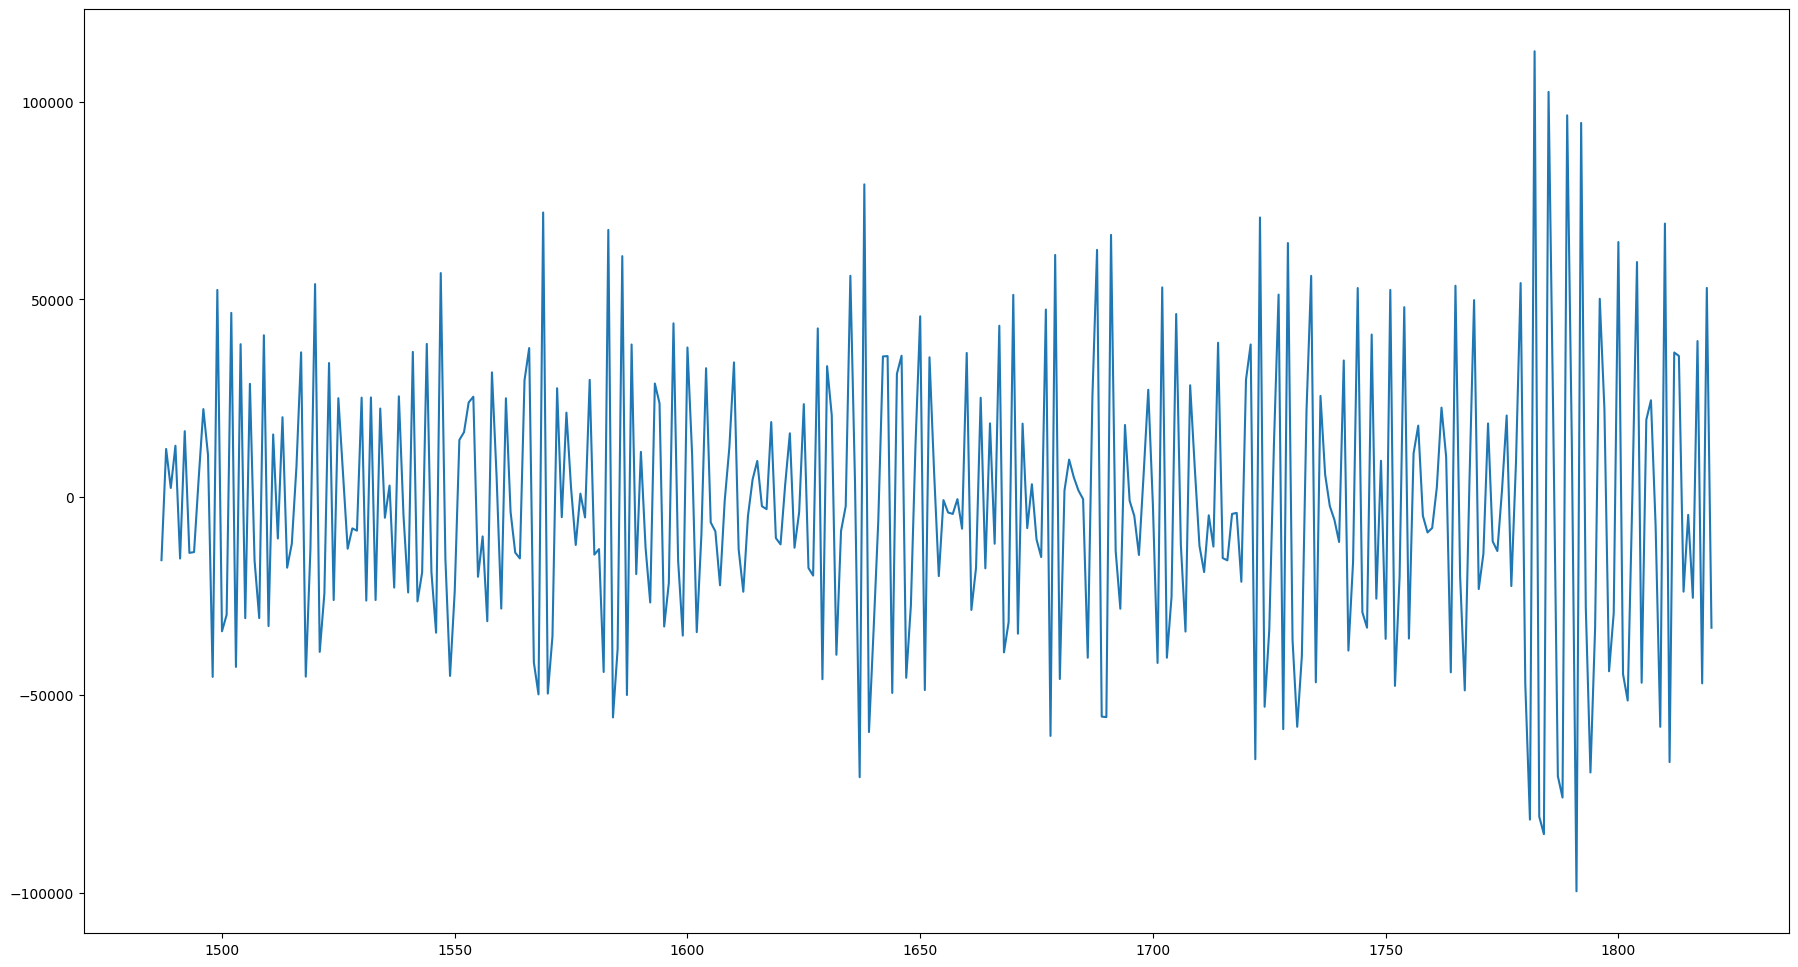

In [82]:
plt.figure(figsize=(22,12))
plt.plot(y_test['y'])

In [100]:
eIMF_df = all_eIMFs_dict['eIMFs_0']
# 학습 데이터와 테스트 데이터 분리
X_train, y_train, X_val, y_val, X_test, y_test, sc = ts_train_val_test(eIMF_df, 30)
my_LSTM_model, LSTM_prediction, LSTM_prediction_normalized = LSTM_model(X_train, y_train, X_val, y_val, X_test, sc, 50)

C:\Users\7info\AppData\Local\Temp\ipykernel_13460\1459628612.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test.loc[:, 'y_norm'] = ts_test_scaled[time_steps:].reshape(-1).copy()



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
448               |448               |lstm_1_units
tanh              |tanh              |activation_1
416               |416               |lstm_2_units
tanh              |tanh              |activation_2
96                |96                |dense_1_units
tanh              |tanh              |activation_3
96                |96                |dense_2_units
relu              |relu              |activation_4
0.0001            |0.0001            |learning_rate

Epoch 1/50
28/39 [====================>.........] - ETA: 2s - loss: 0.5586 - mape: 113.6019 - mae: 0.5695

KeyboardInterrupt: 

In [96]:
a= y_test.reset_index(drop=True)

In [97]:
a['y']

0     -15902.217577
1      12209.958013
2       2351.857075
3      13026.791042
4     -15491.496065
           ...     
329   -25417.865191
330    39476.808102
331   -47049.795104
332    52919.904674
333   -32983.944074
Name: y, Length: 334, dtype: float64

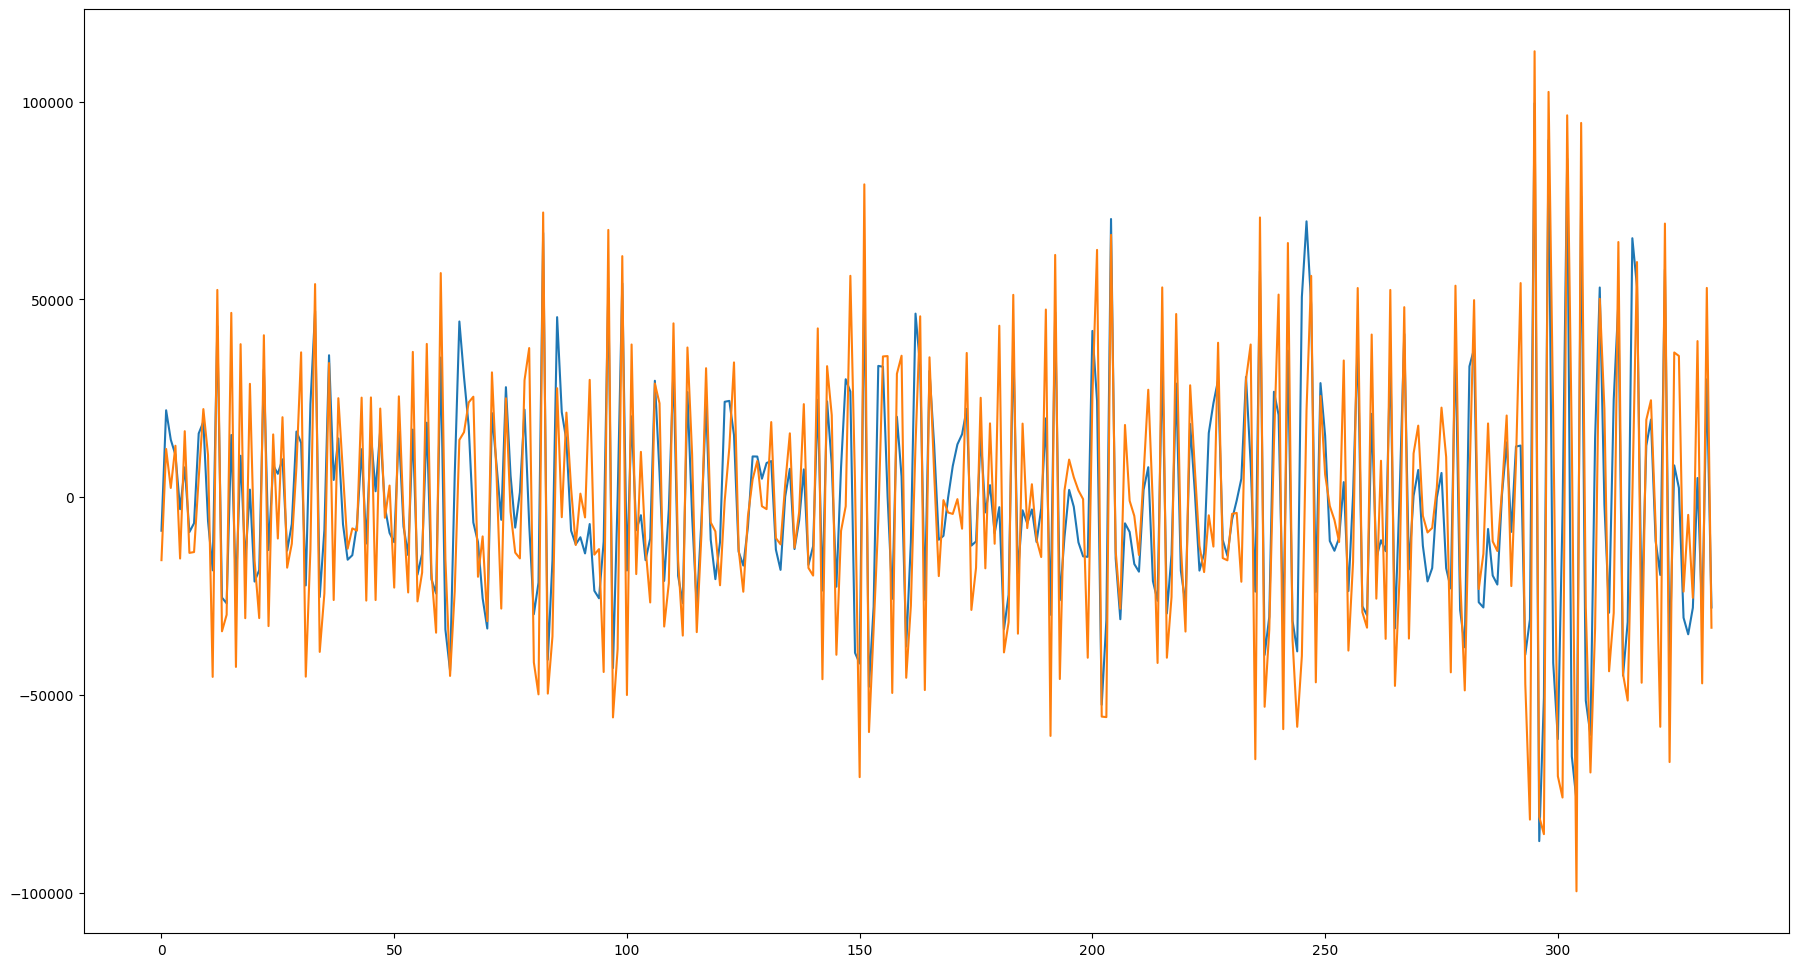

In [99]:
plt.figure(figsize=(22,12))
plt.plot(LSTM_prediction)
plt.plot(a['y'])

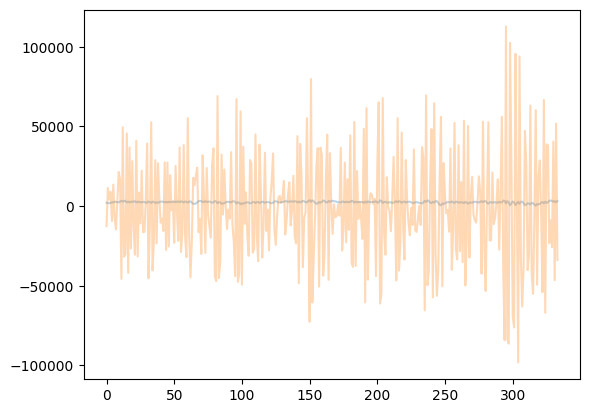

In [21]:
plt.plot(LSTM_prediction, alpha=0.3)
plt.plot(a['y'], alpha=0.3)

In [ ]:
# 학습 데이터와 테스트 데이터 분리
X_train, y_train, X_val, y_val, X_test, y_test, sc = ts_train_val_test(eIMF_df, time_steps)
# LSTM 모델 학습 및 저장
my_LSTM_model, LSTM_prediction, LSTM_prediction_normalized = LSTM_model(X_train, y_train, X_val, y_val, X_test, sc, 1)

        
# 예측 결과 저장
y_test.reset_index(drop=True, inplace=True)
pred_df = pd.DataFrame({'Pred': LSTM_prediction.reshape(-1) ,'Pred_norm': LSTM_prediction_normalized.reshape(-1)})
res_df = pd.concat([y_test, pred_df], axis=1)
res_df.set_index('Date', inplace=True)
res_df = res_df.resample('D').first() # 증강된 데이터가 아닌, Actual값들과 비교

In [39]:
def execute_EEMD_LSTM(product_code, eemd_trials=100, time_steps=30, epochs=30):
    start_time = time.time()
    product_code = product_code # 예측하고자 하는 코드 입력
    product_df = df[df['Product_Code']== product_code].reset_index(drop=True)
    
    # EEMD 수행
    all_eIMFs_df, nIMFs = eemd_fit(product_df, eemd_trials)
    # EEMD 결과에서 각 eIMFs' DF 추출
    all_eIMFs_dict = extract_eIMFs(all_eIMFs_df, nIMFs)
    # EEMD+LSTM 실행
    model_dict, pred_dict = EEMD_LSTM(all_eIMFs_dict, time_steps, epochs) #dictionary, time_steps, epochs
    save_model(product_code, model_dict)
    all_result_df = make_all_result_df(pred_dict)
    # Metric 성능 평가
    metric_df_norm = make_metric_df(product_code, pred_dict, all_result_df, True)
    metric_df = make_metric_df(product_code, pred_dict, all_result_df, False)
    # Pred_Actual Plot
    actual_pred_plot(product_code, pred_dict, all_result_df, metric_df_norm, True)
    actual_pred_plot(product_code, pred_dict, all_result_df, metric_df, False)
    # 실행시간 확인
    elapsed_time_seconds = time.time() - start_time
    elapsed_time_minutes = elapsed_time_seconds / 60
    print("실행 시간: {:.2f} 분".format(elapsed_time_minutes))
    return metric_df

In [51]:
execute_EEMD_LSTM('Product_1378', 100, 30, 50)

--------Total: 0~10 eIMFs, Now: eIMFs_0 --------
INFO:tensorflow:Reloading Tuner from my_dir\helloworld\tuner0.json
INFO:tensorflow:Oracle triggered exit


C:\Users\7info\AppData\Local\Temp\ipykernel_13460\1459628612.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test.loc[:, 'y_norm'] = ts_test_scaled[time_steps:].reshape(-1).copy()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 224)           202496    
                                                                 
 lstm_1 (LSTM)               (None, 256)               492544    
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 96)                6240      
                                                                 
 dense_2 (Dense)             (None, 1)                 97        
                                                                 
Total params: 717,825
Trainable params: 717,825
Non-trainable params: 0
_________________________________________________________________
11/11 [==============================] - 1s 35ms/s

C:\Users\7info\AppData\Local\Temp\ipykernel_13460\1459628612.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test.loc[:, 'y_norm'] = ts_test_scaled[time_steps:].reshape(-1).copy()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 224)           202496    
                                                                 
 lstm_1 (LSTM)               (None, 256)               492544    
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 96)                6240      
                                                                 
 dense_2 (Dense)             (None, 1)                 97        
                                                                 
Total params: 717,825
Trainable params: 717,825
Non-trainable params: 0
_________________________________________________________________
11/11 [==============================] - 1s 31ms/s

C:\Users\7info\AppData\Local\Temp\ipykernel_13460\1459628612.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test.loc[:, 'y_norm'] = ts_test_scaled[time_steps:].reshape(-1).copy()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 224)           202496    
                                                                 
 lstm_1 (LSTM)               (None, 256)               492544    
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 96)                6240      
                                                                 
 dense_2 (Dense)             (None, 1)                 97        
                                                                 
Total params: 717,825
Trainable params: 717,825
Non-trainable params: 0
_________________________________________________________________
11/11 [==============================] - 1s 28ms/s

C:\Users\7info\AppData\Local\Temp\ipykernel_13460\1459628612.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test.loc[:, 'y_norm'] = ts_test_scaled[time_steps:].reshape(-1).copy()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 224)           202496    
                                                                 
 lstm_1 (LSTM)               (None, 256)               492544    
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 96)                6240      
                                                                 
 dense_2 (Dense)             (None, 1)                 97        
                                                                 
Total params: 717,825
Trainable params: 717,825
Non-trainable params: 0
_________________________________________________________________
11/11 [==============================] - 1s 31ms/s

C:\Users\7info\AppData\Local\Temp\ipykernel_13460\1459628612.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test.loc[:, 'y_norm'] = ts_test_scaled[time_steps:].reshape(-1).copy()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 224)           202496    
                                                                 
 lstm_1 (LSTM)               (None, 256)               492544    
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 96)                6240      
                                                                 
 dense_2 (Dense)             (None, 1)                 97        
                                                                 
Total params: 717,825
Trainable params: 717,825
Non-trainable params: 0
_________________________________________________________________
11/11 [==============================] - 1s 27ms/s

C:\Users\7info\AppData\Local\Temp\ipykernel_13460\1459628612.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test.loc[:, 'y_norm'] = ts_test_scaled[time_steps:].reshape(-1).copy()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 224)           202496    
                                                                 
 lstm_1 (LSTM)               (None, 256)               492544    
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 96)                6240      
                                                                 
 dense_2 (Dense)             (None, 1)                 97        
                                                                 
Total params: 717,825
Trainable params: 717,825
Non-trainable params: 0
_________________________________________________________________
11/11 [==============================] - 1s 26ms/s

C:\Users\7info\AppData\Local\Temp\ipykernel_13460\1459628612.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test.loc[:, 'y_norm'] = ts_test_scaled[time_steps:].reshape(-1).copy()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 224)           202496    
                                                                 
 lstm_1 (LSTM)               (None, 256)               492544    
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 96)                6240      
                                                                 
 dense_2 (Dense)             (None, 1)                 97        
                                                                 
Total params: 717,825
Trainable params: 717,825
Non-trainable params: 0
_________________________________________________________________
11/11 [==============================] - 1s 27ms/s

C:\Users\7info\AppData\Local\Temp\ipykernel_13460\1459628612.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test.loc[:, 'y_norm'] = ts_test_scaled[time_steps:].reshape(-1).copy()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 224)           202496    
                                                                 
 lstm_1 (LSTM)               (None, 256)               492544    
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 96)                6240      
                                                                 
 dense_2 (Dense)             (None, 1)                 97        
                                                                 
Total params: 717,825
Trainable params: 717,825
Non-trainable params: 0
_________________________________________________________________
11/11 [==============================] - 1s 25ms/s

C:\Users\7info\AppData\Local\Temp\ipykernel_13460\1459628612.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test.loc[:, 'y_norm'] = ts_test_scaled[time_steps:].reshape(-1).copy()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 224)           202496    
                                                                 
 lstm_1 (LSTM)               (None, 256)               492544    
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 96)                6240      
                                                                 
 dense_2 (Dense)             (None, 1)                 97        
                                                                 
Total params: 717,825
Trainable params: 717,825
Non-trainable params: 0
_________________________________________________________________
11/11 [==============================] - 1s 29ms/s

C:\Users\7info\AppData\Local\Temp\ipykernel_13460\1459628612.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test.loc[:, 'y_norm'] = ts_test_scaled[time_steps:].reshape(-1).copy()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 224)           202496    
                                                                 
 lstm_1 (LSTM)               (None, 256)               492544    
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 96)                6240      
                                                                 
 dense_2 (Dense)             (None, 1)                 97        
                                                                 
Total params: 717,825
Trainable params: 717,825
Non-trainable params: 0
_________________________________________________________________
11/11 [==============================] - 1s 27ms/s

C:\Users\7info\AppData\Local\Temp\ipykernel_13460\1459628612.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test.loc[:, 'y_norm'] = ts_test_scaled[time_steps:].reshape(-1).copy()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 224)           202496    
                                                                 
 lstm_1 (LSTM)               (None, 256)               492544    
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 96)                6240      
                                                                 
 dense_2 (Dense)             (None, 1)                 97        
                                                                 
Total params: 717,825
Trainable params: 717,825
Non-trainable params: 0
_________________________________________________________________
11/11 [==============================] - 1s 25ms/s

,MAPE,RMSE,MAE,NRMSE,NMAE,R2
eIMF_1,2.7499,34116.2865,28260.1806,-19.4802,-16.1364,0.0674
eIMF_2,9.9812,35233.9093,29411.6752,-138.7257,-115.8020,-1.1866
eIMF_3,7.1802,20622.3766,16504.2908,-81.6049,-65.3092,-1.9992
eIMF_4,4.3967,12885.7459,10662.3043,-60.9388,-50.4238,-2.1600
eIMF_5,2.7762,6563.4595,5725.2335,697.7328,608.6247,-1.2589
eIMF_6,4.6864,3943.9159,3170.9000,24.7309,19.8836,-1.9754
eIMF_7,4.5973,4803.2971,4463.6404,27.7893,25.8242,-0.8194
eIMF_8,11.2036,2482.9409,2151.6478,1.4948,1.2954,-1.8810
eIMF_9,0.0164,714.7991,712.8759,0.0165,0.0164,-359.9457
eIMF_10,0.0204,1069.4809,1050.9586,0.0208,0.0204,-42.5253


---

## Whole Process
    - product_code에 str으로 예측하고자 하는 코드를 입력
    - ['Product_0025', 'Product_0739', 'Product_0901', 'Product_1154',
       'Product_1248', 'Product_1295', 'Product_1378', 'Product_2004']

In [ ]:
for code in ['Product_0025', 'Product_0739', 'Product_0901', 'Product_1154',
             'Product_1248', 'Product_1295', 'Product_1378', 'Product_2004']:
    print("==================================")
    print(f"========== { code } ==========")
    print("==================================")
    execute_EEMD_LSTM(code)